# Notebook to illustrate the way Artificial Neurone Networks can speedup the determination of Te and Ne, using getTemDen or getCrossTemDen.

### You need to have installed tensorflow and scikit-learn. The best is to create a dedicated environment, for example following these instruction once anaconda is installed:

```
conda create -n ML pip numpy matplotlib scipy tensorflow scikit-learn keras jupyter jupyterlab ipython pandas pytables astropy h5py catboost

activate ML

pip install -U git+https://github.com/morisset/AI4neb.git

pip install PyNeb
```

**!!! You need to be sure that the regressor behaves correctly by comparing its predictions with the classical way over the whole range of Te and/or Ne you try to determine !!!**

In [2]:
# This is the ANN interface. It may generate a warning, do not worry.
try:
    import ai4neb
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git

2023-11-10 11:44:41.801327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyneb as pn
print(pn.__version__)

1.1.19b2


# Test Atom.getTemDen

In [4]:
O3 = pn.Atom('O',3)
N2 = pn.Atom('N',2)
S2 = pn.Atom('S',2)

In [5]:
# Number of data points to test the ANN option speedup. 
# 1,000 is good to see what's happening. 
# 10,000 starts to really rock.
N_rand = 1000
# Define some ramdom values to test the 
ratio = 150.+ 10*np.random.randn(N_rand)
den =  150.+ 10*np.random.randn(N_rand)
ratio_S2 = 1 + 0.1*np.random.randn(N_rand)
tem_S2 = 11000 + 2000 * np.random.randn(N_rand)

### Using the classical way

In [6]:
pn.config.unuse_multiprocs()

In [7]:
start = time.time()
resa = O3.getTemDen(ratio, den=1e2, wave1=5007, wave2=4363)

resb = O3.getTemDen(ratio, den=den, wave1=5007, wave2=4363)
resc = N2.getTemDen(ratio, den=den,
                       to_eval = '(L(6584) + L(6548)) / L(5755)')
resd = S2.getTemDen(ratio_S2, tem=11000, wave1=6716, wave2=6731)

rese = S2.getTemDen(ratio_S2, tem=tem_S2, wave1=6716, wave2=6731)
end = time.time()
print(end-start)

35.26158547401428


### Using the classical way, but with the multiproceesing option, that already may accelerate the process.

In [10]:
pn.config.use_multiprocs()
print(f'Number of CPU found: {pn.config.Nprocs}.')

Number of CPU found: 8.


In [9]:
start = time.time()
resa = O3.getTemDen(ratio, den=1e2, wave1=5007, wave2=4363)

resb = O3.getTemDen(ratio, den=den, wave1=5007, wave2=4363)
resc = N2.getTemDen(ratio, den=den,
                       to_eval = '(L(6584) + L(6548)) / L(5755)')
resd = S2.getTemDen(ratio_S2, tem=11000, wave1=6716, wave2=6731)

rese = S2.getTemDen(ratio_S2, tem=tem_S2, wave1=6716, wave2=6731)
end = time.time()
print(end-start)

17.823450088500977


### Using the Neuron Network. Only add method='ANN' keyword. 

In [11]:
start = time.time()
# Set the Artificial Neuron Network verobosity to True:
O3.ANN_inst_kwargs['verbose'] = True
res2a = O3.getTemDen(ratio, den=1e2, wave1=5007, wave2=4363, method='ANN')

res2b = O3.getTemDen(ratio, den=den, wave1=5007, wave2=4363, method='ANN')
N2.ANN_inst_kwargs['verbose'] = True
res2c = N2.getTemDen(ratio, den=den,
                     to_eval = '(L(6584) + L(6548)) / L(5755)',
                     method='ANN')
S2.ANN_inst_kwargs['verbose'] = True
res2d = S2.getTemDen(ratio_S2, tem=11000, wave1=6716, wave2=6731,
                     method='ANN', end_x=1e4)
res2e = S2.getTemDen(ratio_S2, tem=tem_S2, wave1=6716, wave2=6731,
                     method='ANN', end_x=1e4)

end = time.time()
print(end-start)

Instantiation. V 0.17
Training set size = 30, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 30, Test set size = 0
Training set size = 30, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 1 outputs with 30 data
RM trained, with 297 iterations. Score = 1.000
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 10), max_iter=20000,
             solver='lbfgs', tol=1e-06)
Training time 0.1 s.
Test data scaled. Log10 applied. 
Training set size = 30, Test set size = 1000
Predicting from 2 inputs to 1 outputs using 1000 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 1 outputs with 900 data
RM trained, with 517 iterations. Score = 1.000
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 10), max_iter=20000

In [12]:
# Compare the results
print(np.mean(resa/res2a), np.std(resa/res2a))
print(np.mean(resb/res2b), np.std(resb/res2b))
print(np.mean(resc/res2c), np.std(resc/res2c))
print(np.mean(resd/res2d), np.std(resd/res2d))
print(np.mean(rese/res2e), np.std(rese/res2e))

0.9864408885046475 0.0014792679399446762
1.002057419935483 0.00092559980735218
1.003533214318648 0.001152063857733191
0.9972602593126836 0.0037557618330814604
0.995504462701349 0.006047919285667321


# Test diagnostics.getCrossTemDen

In [15]:
# Number of data for which we want to determine Te and Ne:
N = 2000 

rO3 = 0.0050 * (1 + 0.6*np.random.randn(N))
rN2 = 0.0080 * (1 + 0.6*np.random.randn(N))
rS2 = 1.5 * (1 + 0.7*np.random.randn(N))

In [30]:
diags = pn.Diagnostics()

In [20]:
# Normal way: looking for the point where both diagnostics coincide:
pn.config.use_multiprocs()
start = time.time()
tem, den = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2)
tem2, den2 = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2)
end = time.time()
print('time for classical method using multiprocs: {:1f} s.'.format(end - start))

time for classical method using multiprocs: 190.222687 s.


### Using Machine Learning. 

In [31]:
# Set up some parameters of the Regresor Method object
diags.ANN_inst_kwargs = {'RM_type' : 'SK_ANN', 
                         'verbose' : True, 
                         'scaling' : True,
                         'use_log' : True,
                         'random_seed' : 43
                                }

# Set up some parameters of the Analogic Neural Network
diags.ANN_init_kwargs = {'hidden_layer_sizes' : (10, 30, 10),
                         'activation' : 'tanh',
                         'solver' : 'lbfgs', 
                         'max_iter' : 20000} 

diags.ANN_n_tem = 30
diags.ANN_n_den = 30

In [35]:
# Compute Te and Ne using the ANN. Print scoring at training
start = time.time()
temNN, denNN = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', 
                                    rO3, rS2, 
                                    use_ANN=True, 
                                    start_den=10, end_den=1e6, 
                                    start_tem=3000, end_tem=20000,
                                    limit_res=False)
diags.ANN.save_RM('O3_S2')
print(diags.ANN.train_score)
temNN2, denNN2 = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', 
                                      rN2, rS2, 
                                      use_ANN=True, 
                                      start_den=10, end_den=1e6, 
                                      start_tem=3000, end_tem=20000,
                                      limit_res=False)
diags.ANN.save_RM('N2_S2')
print(diags.ANN.train_score)
end2 = time.time()
print('time for ANN method: {:1f} s.'.format(end2 - start))

Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 4607 iterations. Score = 0.998
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             random_state=43, solver='lbfgs')
Training time 6.4 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1755
Predicting from 2 inputs to 2 outputs using 1755 data in 0.00 secs.
RM save to O3_S2.ai4neb_sk
[0.9979524653336549]
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 7159 iterations. Score = 0.999
MLPRegress

### The same as the previous cell, but reading the ML parameters (no Training). **Very faster!!!**

In [38]:
# Compute Te and Ne using the ANN. Read the ANNs stored in the previous ceel:; no training anymore.
start = time.time()
temNN, denNN = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', 
                                    rO3, rS2, 
                                    use_ANN=True, limit_res=False, ANN='O3_S2')
print(diags.ANN.train_score)
temNN2, denNN2 = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', 
                                      rN2, rS2, 
                                      use_ANN=True, limit_res=False, ANN='N2_S2')
print(diags.ANN.train_score)
end2 = time.time()
print('time for ANN method: {:1f} s.'.format(end2 - start))

[0.9979524653336549]
[0.9988806693054997]
time for ANN method: 0.009351 s.


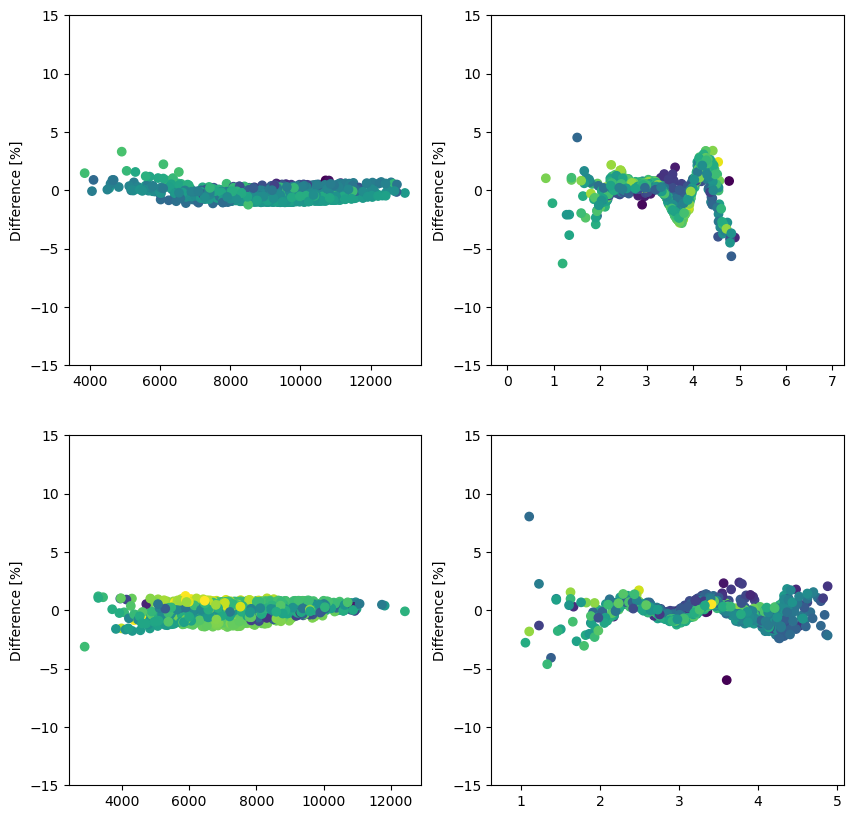

In [39]:
# PLots comparing the results obtained by the classicla method and the ANN one
# ANN is interpolating, while classicla method is looking for a zero.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.scatter(tem, (temNN-tem)/tem*100, c=np.log10(den))
ax2.scatter(np.log10(den), (denNN-den)/den*100, c=tem)
ax3.scatter(tem2, (temNN2-tem2)/tem2*100, c=np.log10(den2))
ax4.scatter(np.log10(den2), (denNN2-den2)/den2*100, c=tem2);
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel('Difference [%]')
    ax.set_ylim(-15, 15)

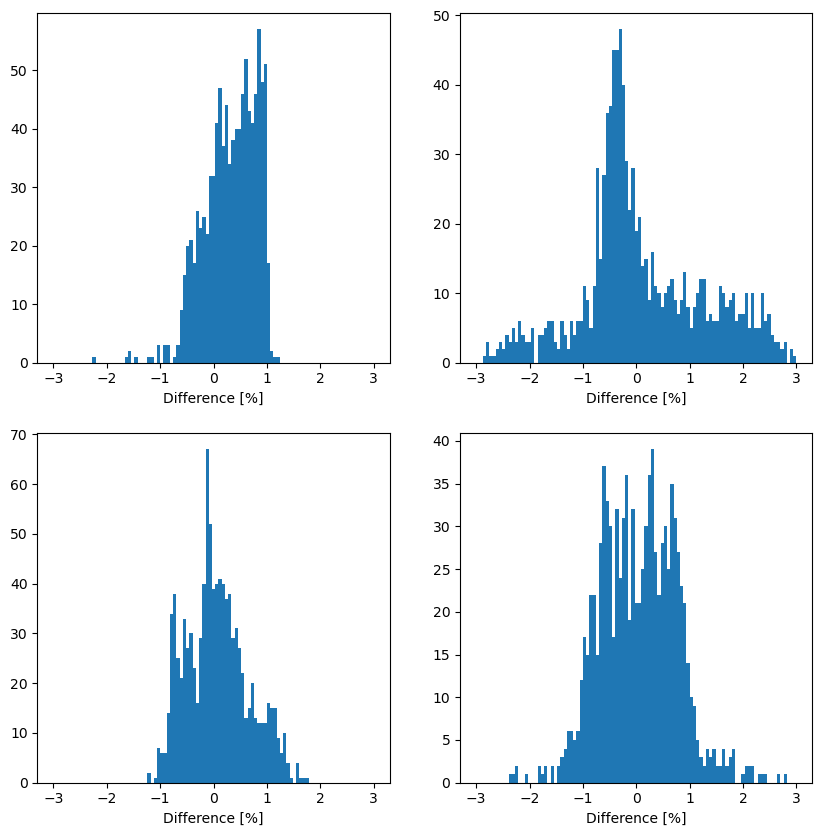

In [40]:
# Histograms of the differences. Not that bad indeed.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
bins = np.linspace(-3, 3, 100)
ax1.hist((tem-temNN)/tem*100, bins=bins)
ax2.hist((den-denNN)/den*100, bins=bins);
ax3.hist((tem2-temNN2)/tem2*100, bins=bins)
ax4.hist((den2-denNN2)/den2*100, bins=bins);
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Difference [%]')

### Now we run 4 more ANN to make a mean of the 5 results obtained. Takes time, but if one have 10s of thousands of data, it deserves it.

In [41]:
diags.ANN_inst_kwargs['random_seed'] = 42
temNNb, denNNb = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2b, denNN2b = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 44
temNNc, denNNc = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2c, denNN2c = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 45
temNNd, denNNd = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2d, denNN2d = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 46
temNNe, denNNe = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2e, denNN2e = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)

Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 10992 iterations. Score = 0.999
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             random_state=42, solver='lbfgs')
Training time 15.6 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1755
Predicting from 2 inputs to 2 outputs using 1755 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 6331 iterations. Score = 0.999
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 

In [42]:
# Compute the median of the 5 runs.
temNNm = np.median(np.array((temNN, temNNb, temNNc, temNNd, temNNe)),0)
temNN2m = np.median(np.array((temNN2, temNN2b, temNN2c, temNN2d, temNN2e)),0)
denNNm = np.median(np.array((denNN, denNNb, denNNc, denNNd, denNNe)),0)
denNN2m = np.median(np.array((denNN2, denNN2b, denNN2c, denNN2d, denNN2e)),0)

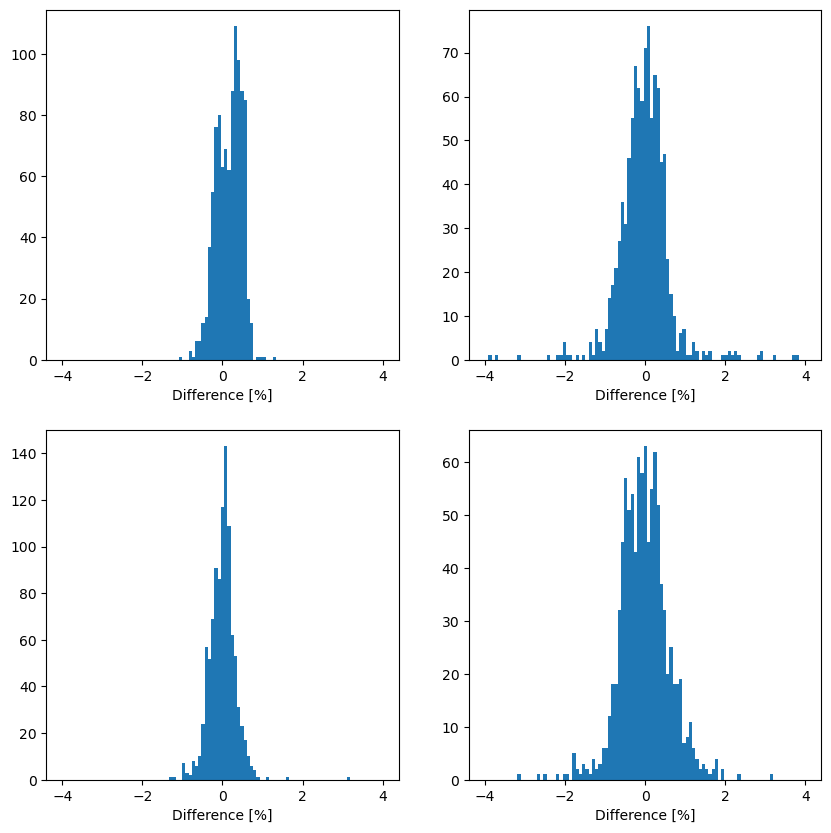

In [43]:
# Histogram of the differences: even better now.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist((tem-temNNm)/tem*100, bins=np.linspace(-4, 4, 100))
ax2.hist((den-denNNm)/den*100, bins=np.linspace(-4, 4, 100));
ax3.hist((tem2-temNN2m)/tem2*100, bins=np.linspace(-4, 4, 100))
ax4.hist((den2-denNN2m)/den2*100, bins=np.linspace(-4, 4, 100));
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Difference [%]')